<a href="https://colab.research.google.com/github/avranasa/Coded-ResNeXt/blob/main/Coded_ResNeXt_Imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git@bits_and_tpu
!apt-get install -q subversion
!svn checkout https://github.com/avranasa/Coded-ResNeXt.git/trunk/Imagenet /content/Imagenet
!pip uninstall -y torch
!pip install torch==1.8.2+cpu  torchvision==0.9.2+cpu -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_2_tar_files = '/content/drive/MyDrive/Imagenet'

#The path_2_tar_files should contain the: "meta.bin", "ILSVRC2012_img_val.tar",
#ILSVRC2012_devkit_t12.tar.gz, and a folder named "train" containing the tar files
#which each contain the images per class used for training. Those files are created 
#by extracting the ILSVRC2012_img_train.tar and look like: n01440764.tar, n01443537.tar,...


#The following lines will extract from the directory: path_2_tar_files/train/ 
#the images for every class used for training and create a directory: data_dir/train/
#where it will create a folder per class putting there the images for each class.
#Lastly the images for validation will be saved in a directory: data_dir/val/

#This procedure will take around 45 minutes. It was the fastest procedure we found that could 
#also fit in the 182GB available memory in the disk. We tried also to transfer locally the 
#whole ILSVRC2012_img_train.tar and locally extract it. Also we tried extracting
#all the images in the google drive and the dataloader fetching batches from the drive.
#Both of those approach failed or were much slower. 
import sys
sys.path.insert(0, '/content/Imagenet')
from DatasetImagenet import MyImageNet
data_dir = "/content/"
MyImageNet(root= data_dir, path_2_files= path_2_tar_files, split='train')
MyImageNet(root= data_dir, path_2_files= path_2_tar_files , split='val')

In [ ]:
'''
Below the directory /content/ is the same as the "data_dir" of the previous cell where the training images were saved.
IMPORTANT: With subscription COLAB Pro the session is active only for 12 hours and with COLAB Pro+ it is 24 hours but each epoch 
           takes about 45 minutes. So to be  able to train for 150 epochs we had to save a checkpoint every epoch and when the 
           session is terminated, we restart a session and continue the training from the last saved checkpoint. Therefore the 
           checkpoints must NOT be saved LOCALLY but somewhere permanently. We save them in our personal the google drive. The exact
           saving directory is defined as the argument of --output (in this case it is  /content/drive/MyDrive/Example ).

           When restarting the session we continue the training from the last saved checkpoint by passing the argument:
           --resume /content/drive/MyDrive/Example/New_experiment/last.pth.tar

Description of main added arguments:
    --Control: Runs the baseline ResNeXt. Therefore the arguments (e.g. Coef-LossDisentangle, dp-prob, coding-ratio-per-stage)
               related to coded-ResNeXt will not play any role.
    --Coef-LossDisentangle: The coefficient with which the coding loss is multiplied (in the paper is denoted with $\mu$)
    --dp-prob: The dropSubNN probability (in the paper it is denoted with $p_{drop}$). It is applied to all the blocks that 
               with a coding scheme of ratio $r_l<1$ and with the same probability.
    --coding-ratio-per-stage: The ratios of the coding schemes that are applied per stage. Assumption of using (Coded-)ResNeXt
              which has 4 stages, so 4 inputs should be given. Default: '32/32' '32/32' '16/32' '8/32'. Also it is assumed
              that all blocks within  a stage have the same ratio.
              If the user wants to experiment more without those assumptions, please go to the  CodedResNeXt.py file to
              change directly the "ARCHITECTURE_IMAGENET". More details can be found in that file.
'''

!python /content/Imagenet/launch_xla.py --num-devices 8  /content/Imagenet/train.py /content/ \
    --output /content/drive/MyDrive/Example  --experiment New_experiment\
    --Coef-LossDisentangle 2.0 --dp-prob 0.1 --coding-ratio-per-stage 32/32 32/32 16/32 8/32\
    -b 128 -vb 128 -j 2 --input-size 3 160 160 --aa rand-m10-n2 --epochs 150 --cooldown-epochs 0 --lr .4   --warmup-epochs 5  --sched cosine  --checkpoint-hist 1
    #--resume /content/drive/MyDrive/Example/New_experiment/last.pth.tar

In [3]:
'''
An example of how to run the experiment of removing randomly subNNs from a given block. Load the Coded-ResNeXt model (which below
we do it from the fictitious checkpoint /content/drive/MyDrive/Example/New_experiment/last.pth.tar). Then use the argument:
--Remove-subNNs-from-block : Provide two or more integers. The first integer denotes the index of the block 
                            from which subNNs will be removed. Two ways of removing: first from the 
                            set of inactive subNNs and second from the set of active. How many subNNs will be 
                            removed is determined by the rest of the provided integers. In the example below 
                            it is given: 14 4 7 , so  then from the 14-th block first 4 subNNs will be 
                            randomly removed in the two ways (per validation sample) and then the experiment 
                            will be repeated with 7.
                            Note that in the paper we start indexing the blocks from 1 but in the code from 0.
                            So the 5-th for example block of the paper here it will be the 6-th.
'''

!python /content/Imagenet/launch_xla.py --num-devices 8  /content/Imagenet/train.py /content/ \
    -b 128 -vb 128 -j 2 --input-size 3 160 160 \
    --Remove-subNNs-from-block 14 4 7\
    --resume /content/drive/MyDrive/Example/New_experiment/last.pth.tar
  

Initialized device xla:1. Rank: 0 (0) of 8.
DeviceEnvXla(device=device(type='xla', index=1), world_size=8, local_rank=0, global_rank=0, amp=False, autocast=<class 'contextlib.suppress'>, memory_format=None, dtype=None)
Your arguments for the experiment - new_experiment - are:
     Control:  False
     Energy_normalization:  True
     Same_code_Same_mask:  True
     LossDisentangle_type:  power4_threshold0.0
     Coef_LossDisentangle:  1.0
     Dropout SubNN prob. :  0.1
     Mask_grads:  False
     Coding Ratios per stage: ['32/32', '32/32', '16/32', '8/32']
Saving at directory:  /
And the experiment name:  new_experiment
Training in distributed mode with multiple processes, 1 device per process. Process 0, total 8.
Initialized device xla:0. Rank: 2 (2) of 8.
DeviceEnvXla(device=device(type='xla', index=0), world_size=8, local_rank=2, global_rank=2, amp=False, autocast=<class 'contextlib.suppress'>, memory_format=None, dtype=None)
Training in distributed mode with multiple processes, 1

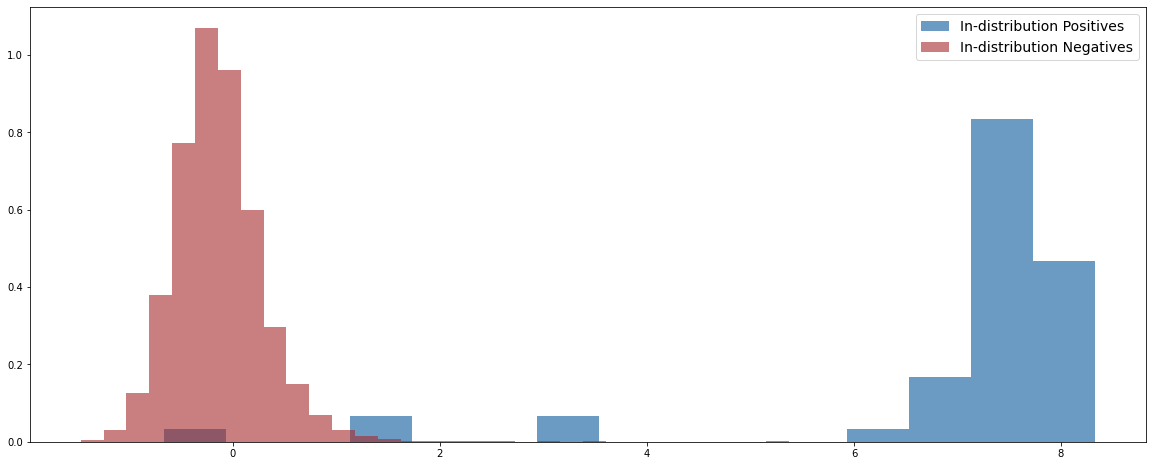

In [9]:
'''
An example of how to run the experiment of testing a binary classifier and plotting the distribution for the positive and
negative samples. Load the trained Coded-ResNeXt model (which below we do it from a made up checkpoint 
/content/drive/MyDrive/Example/New_experiment/last.pth.tar). In the output path (here /content/Example ) will be saved 8 
(equal to the number of cores of TPU) txt files with the output of the binary classifier. To choose for what class it will 
be the extracted binary classifier use the argument:
    --BinaryClassifier: An integer (from 0 to 999 since Imagenet has 1000 classes) indicating  for which the class a binary
                        classifier will be extracted.
'''

!python /content/Imagenet/launch_xla.py --num-devices 8  /content/Imagenet/train.py /content/ \
    -b 128 -vb 128 -j 2 --input-size 3 160 160 \
    --BinaryClassifier 0  --output  /content/Example \
    --resume /content/drive/MyDrive/Example/New_experiment/last.pth.tar

import glob
import pickle
import torch
import matplotlib.pyplot as plt

Outputs, Labels, ActualPos, ActualNeg = [],[], [], []
for f in glob.iglob('/content/Example/class_0/*.txt'):
    with open(f, "rb") as fp:  
        Out, label = pickle.load(fp)
        Outputs.append(Out)
        Labels.append(label)
Outputs = torch.cat(Outputs)
Labels = torch.cat(Labels)
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=False, figsize = (20,8))
for o, l in zip(Outputs, Labels):
    if l == 0:  #the binary classifier for class 0
        ActualPos.append(o)
    else: 
        ActualNeg.append(o)
axs.hist(ActualPos, density=True, bins=15, alpha=0.8, label='In-distribution Positives',color='steelblue')
axs.hist(ActualNeg , density=True, bins=40, alpha=0.6, label='In-distribution Negatives', color='brown')
axs.legend(fontsize=14)
plt.show()
